- last two weeks we used all kinds of linear regression models
- including forward stepwise regression, lasso, ridge, and elastic net
- this week we move on to multiple addictive regression models
- such as gradient boosting trees
- other models like random forest, bagging are quite similar


- among them boosting tress are the most famous and powerful
- there are several packages in this filed
- the oldest one is gbm
- the package h2o includes a parallel version of gbm
- and a newer one which has the best performance on kaggle competition is xgboost
- and currently Microsoft developed an even better package called lightgbm
- these week we can try on these models to see whether they can acutally boost our performance


- first we can install lightgbm from the zip file I sent to you
- for linux users maybe you can follow the instruction online, and it would be easier

In [1]:
# https://github.com/Laurae2/lgbdl
# https://github.com/r-dbi/RPostgres/issues/110

In [98]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [97]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [3]:
product_list = ["rb", "hc", "i", "j", "jm"]

In [4]:
period = 4096

In [5]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 915

915

In [6]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

- fix a bug in week2
- it may affect previous result but the result is still accpetable

In [8]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [9]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

- let's begin with week 10
- we can load xgboost and lightgbm at first

In [11]:
import xgboost as xgb
import lightgbm as lgb
import os

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [13]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [14]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")

print(product_list[0], train_mat.shape)
for product in ["hc","j","jm"]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)
# rb (5266, 48)
# hc (3894, 48)
# j (3118, 48)
# jm (2999, 48)

rb (5266, 48)
hc (3894, 48)
j (3118, 48)
jm (2999, 48)


In [32]:
train_std_mat = dict([])
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[0:0]
test_mat = train_mat
for product in product_list:
    cur_train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_train_mat)
    train_mat = train_mat.append(cur_train_mat/train_std_mat[product])
    cur_test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    test_mat = test_mat.append(cur_test_mat/train_std_mat[product])

In [34]:
print(train_mat.shape)
print(test_mat.shape)

(19935, 48)
(16751, 48)


In [35]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values

In [36]:
strat = "gbm.1"

- create a directory for the first strate

In [37]:
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [51]:
gb1 = GradientBoostingRegressor(random_state=0)
param_grid = {
        'n_estimators': np.arange(10,100,10),
        'max_depth': [1,2,3,4,5,6,7,8,9,10],
        'learning_rate':[0.01,0.1],
        'min_samples_leaf': [10,20], 
    
}

In [52]:
%%time
gbm1 = GridSearchCV(gb1, param_grid, n_jobs=CORE_NUM, cv=5);
gbm1.fit(x_train, y_train);
# Wall time: 40min 18s


Wall time: 40min 18s


In [67]:
x_train.shape

(19935, 45)

In [56]:
print('Gradient boosted tree regression...')
print('Best Params:')
print(gbm1.best_params_)
print('Best CV Score:')
print(gbm1.best_score_)
save(gbm1, HEAD_PATH+"/gbm1.pkl")
# Gradient boosted tree regression...
# Best Params:
# {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 90}
# Best CV Score:
# 0.0012485661741249213




Gradient boosted tree regression...
Best Params:
{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 90}
Best CV Score:
0.0012485661741249213


In [99]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=gbm1, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
;
# Wall time: 29min 12s

Wall time: 29min 12s


In [100]:
signal_name = strat
print(strat)

gbm.1


In [101]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH="e:/intern")

## Wall time: 1min 34s


Wall time: 1min 34s


In [106]:
##
for product in product_list:
    S = load(SAVE_PATH+"/all signal/"+product+".gbm.1.pkl")
    save(S, HEAD_PATH+"/all signal/"+product+".gbm.1.4096.pkl")

In [109]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("gbm.1", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 11min 19s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 11min 19s


rb train sharpe  0.6251495093396922 test sharpe  -0.05372465458218983
hc train sharpe  1.2513266364780318 test sharpe  1.0323501354648408
j train sharpe  1.3741905588935035 test sharpe  -0.4888457591691928
jm train sharpe  1.0541437886238547 test sharpe  1.1297954261170637
train sharpe:  1.6976336898103017 test sharpe:  1.0813974003256637


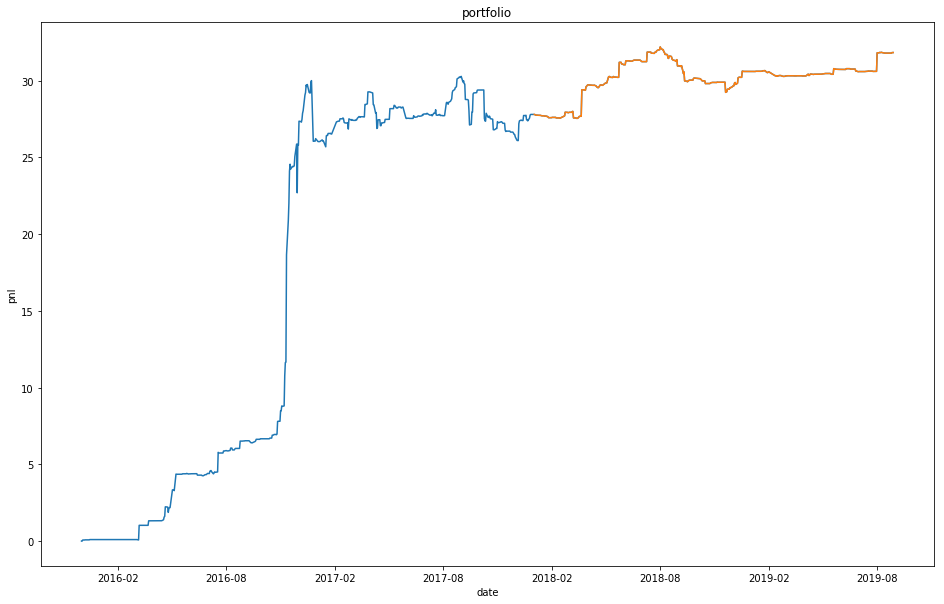

In [111]:
i = 0
strat = "gbm.1.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in ["rb","hc","j","jm"]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    
# rb train sharpe  0.6251495093396922 test sharpe  -0.05372465458218983
# hc train sharpe  1.2513266364780318 test sharpe  1.0323501354648408
# j train sharpe  1.3741905588935035 test sharpe  -0.4888457591691928
# jm train sharpe  1.0541437886238547 test sharpe  1.1297954261170637
# train sharpe:  1.6976336898103017 test sharpe:  1.0813974003256637

## result of week9
# rb train sharpe  1.1573394555359664 test sharpe  1.5067433544527522
# hc train sharpe  1.4029104175429374 test sharpe  0.44701175768572476
# i train sharpe  1.0578039802590233 test sharpe  0.7404904012321055
# j train sharpe  1.882628152705039 test sharpe  1.4707256045526333
# jm train sharpe  1.169831922470172 test sharpe  0.7730535623940026
# train sharpe:  2.0557422122189277 test sharpe:  1.9364802070196268

- we can see that the result is not good


- Now let's start with xgboost

In [28]:
import xgboost as xgb

- we need to create specific train and test data sets for xgboost

In [118]:
cv_params = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 
             'n_estimators': np.arange(10,100,10)}
ind_params = {'learning_rate': 0.01,
              "min_samples_leaf":[10,20],
              'seed':100, 'objective': 'reg:linear'}
xgb_cv = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                            cv = 5, n_jobs = -1) 

In [137]:
%%time
xgb_cv.fit(x_train, y_train);
#Wall time: 7min 55s
# GridSearchCV(cv=5, error_score='raise-deprecating',
#              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
#                                     colsample_bylevel=1, colsample_bytree=1,
#                                     gamma=0, importance_type='gain',
#                                     learning_rate=0.01, max_delta_step=0,
#                                     max_depth=3, min_child_weight=1,
#                                     min_samples_leaf=[10, 20], missing=None,
#                                     n_estimators=100, n_jobs=1, nthread=None,
#                                     objective='reg:linear', random_state=0,
#                                     reg_alpha=0, reg_lambda=1,
#                                     scale_pos_weight=1, seed=100, silent=True,
#                                     subsample=1),
#              iid='warn', n_jobs=-1,
#              param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#                          'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
#              pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
#              scoring=None, verbose=0)

Wall time: 7min 53s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.01, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    min_samples_leaf=[10, 20], missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=100, silent=True,
                                    subsample=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': array([10, 20, 30,

In [138]:
#best_parameters, score, _ = max(xgb_cv.grid_scorer, key=lambda x: x[1])
xgb_cv.best_params_
##{'max_depth': 4, 'n_estimators': 90}

{'max_depth': 4, 'n_estimators': 90}

In [139]:
strat = "xgb.002.4096"
signal_name = strat

In [145]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)


- we can plot them to check the result

In [146]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=xgb_cv, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
;
#Wall time: 29min 14s


Wall time: 29min 14s


In [147]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH="e:/intern")

Wall time: 1min 6s


In [148]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("xgb.002", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 11min 19s

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 10min 41s


rb train sharpe  0.7611873331034595 test sharpe  -0.545526323273333
hc train sharpe  0.872762897147428 test sharpe  -1.8424022923600454
j train sharpe  0.9203639493679677 test sharpe  -0.7096122306661015
jm train sharpe  1.1985146326781144 test sharpe  -0.6296506079029357
train sharpe:  1.5744211313443015 test sharpe:  -1.5074723327388744


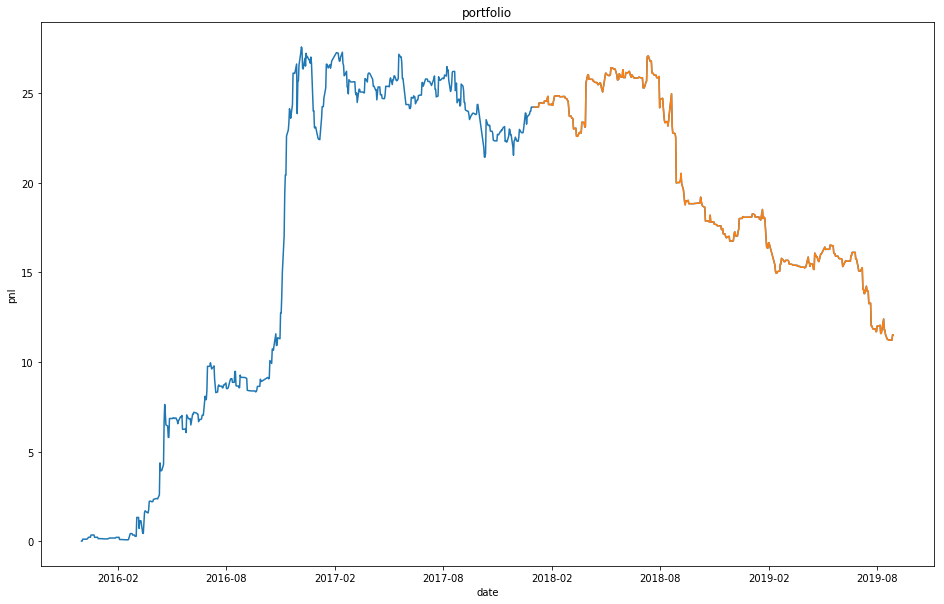

In [149]:
i = 0
strat = "xgb.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in ["rb","hc","j","jm"]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    
# rb train sharpe  0.7611873331034595 test sharpe  -0.545526323273333
# hc train sharpe  0.872762897147428 test sharpe  -1.8424022923600454
# j train sharpe  0.9203639493679677 test sharpe  -0.7096122306661015
# jm train sharpe  1.1985146326781144 test sharpe  -0.6296506079029357
# train sharpe:  1.5744211313443015 test sharpe:  -1.5074723327388744


## result of week9
# rb train sharpe  1.1573394555359664 test sharpe  1.5067433544527522
# hc train sharpe  1.4029104175429374 test sharpe  0.44701175768572476
# i train sharpe  1.0578039802590233 test sharpe  0.7404904012321055
# j train sharpe  1.882628152705039 test sharpe  1.4707256045526333
# jm train sharpe  1.169831922470172 test sharpe  0.7730535623940026
# train sharpe:  2.0557422122189277 test sharpe:  1.9364802070196268


- SUMMARY


- today we compare two tree-based models: gradient boosting machine and xgboost
- but the result is pretty bad
- you can try to tune the parameter to see whether we could improve it